In [12]:
import os, random
import cv2
import math
import librosa
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from tqdm import tqdm

from collections import Counter

import torch
import torchaudio
from torch import nn
import torch.nn.functional as F
from torch.utils.data import WeightedRandomSampler
from torchvision.models import efficientnet
from torchvision.transforms import transforms
# from efficientnet_pytorch import EfficientNet

import timm

import scikitplot as skplt
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder

from glob import glob
from IPython.display import display, Audio

import cupy as cp
from cupyx.scipy import signal as cupy_signal
from scipy import signal as sci_signal

import yaml

from metric import score

import wandb

import plotly.graph_objects as go
import plotly.express as px

import albumentations as albu

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [14]:
default_config = {
    "VERSION": "v0.3",
    "DATA_PATH": "inputs",
    "LOAD_SPEC_DATA": True,
    "SEED": 24,
    "SAMPLE_RATE": 32000,
    "N_FFT": 2048,
    "WIN_SIZE": 412,
    "WIN_LAP": 100,
    "MIN_FREQ": 20,
    "MAX_FREQ": 16000,
    "EPOCHS": 10,
    "BACHSIZE": 16
}

try:
    with open('config.yaml', 'r') as f:
        default_config = yaml.load(f, Loader=yaml.SafeLoader)
except:
    pass

default_config

{'VERSION': 'v3.5',
 'DESCRIPTION': 'top 5 google with stride 1s',
 'DATA_PATH': 'inputs',
 'BACKBONE': 'tf_efficientnet_b0.in1k',
 'LOAD_SPEC_DATA': ['data/melspec_googletop5_256_256_24_wide.npy'],
 'IMAGE_SIZE': 256,
 'SEED': 24,
 'SECOND_LABEL': 1,
 'SAMPLE_RATE': 32000,
 'MIN_FREQ': 20,
 'MAX_FREQ': 16000,
 'N_FFT': 2048,
 'WIN_SIZE': 412,
 'WIN_LAP': 100,
 'N_MEL': 128,
 'HOP_LENGTH': 512,
 'NORMALIZED': True,
 'CENTER': True,
 'PAD_MODE': 'constant',
 'NORM': 'slaney',
 'MEL_SCALE': 'slaney',
 'XYMasking': True,
 'CoarseDropout': True,
 'HorizontalFlip': True,
 'MixUp': True,
 'EPOCHS': 15,
 'FOLD': 2,
 'BACTHSIZE': 16,
 'LABEL_SMOOTHING': 0.0,
 'LOSS': 'FocalLoss'}

In [15]:
meta_data = pd.read_csv(f"inputs/train_metadata.csv")
meta_data.drop_duplicates(inplace=True)

meta_data.reset_index(drop=True, inplace=True)
meta_data = meta_data[["filename","primary_label"]]
meta_data

filename primary_label
0       asbfly/XC134896.ogg        asbfly
1       asbfly/XC164848.ogg        asbfly
2       asbfly/XC175797.ogg        asbfly
3       asbfly/XC207738.ogg        asbfly
4       asbfly/XC209218.ogg        asbfly
...                     ...           ...
24454  zitcis1/XC845747.ogg       zitcis1
24455  zitcis1/XC845817.ogg       zitcis1
24456  zitcis1/XC856176.ogg       zitcis1
24457  zitcis1/XC856723.ogg       zitcis1
24458  zitcis1/XC858550.ogg       zitcis1

[24459 rows x 2 columns]

In [16]:
google_start_birdcall = np.load("data/spec_google_stride1s_bird_start.npy", allow_pickle=True).item()
google_start_birdcall

{'asbfly/XC134896.ogg': [5, 20, 15, 10, 0],
 'asbfly/XC164848.ogg': [10, 5, 0],
 'asbfly/XC175797.ogg': [5, 0, 10, 20, 15],
 'asbfly/XC207738.ogg': [0, 5],
 'asbfly/XC209218.ogg': [35, 5, 40, 10, 25, 30, 20, 15, 0],
 'asbfly/XC209219.ogg': [20, 5, 10, 15, 0, 25],
 'asbfly/XC267679.ogg': [10, 5, 0],
 'asbfly/XC267680.ogg': [15, 10, 20, 25, 0, 5],
 'asbfly/XC267681.ogg': [35,
  75,
  40,
  20,
  105,
  30,
  0,
  60,
  25,
  15,
  50,
  95,
  70,
  10,
  85,
  90,
  55,
  65,
  100,
  80,
  45,
  5,
  110],
 'asbfly/XC267682.ogg': [35, 30, 0, 10, 15, 5, 20, 25],
 'asbfly/XC267683.ogg': [5, 0],
 'asbfly/XC291450.ogg': [15, 20, 10, 25, 5, 0],
 'asbfly/XC305518.ogg': [95,
  30,
  40,
  0,
  70,
  25,
  75,
  35,
  90,
  80,
  55,
  65,
  10,
  5,
  110,
  45,
  20,
  85,
  15,
  50,
  100,
  105,
  60],
 'asbfly/XC309402.ogg': [5, 30, 10, 0, 20, 25, 15],
 'asbfly/XC312456.ogg': [0],
 'asbfly/XC313835.ogg': [55,
  5,
  0,
  20,
  35,
  40,
  45,
  70,
  15,
  75,
  65,
  60,
  30,
  50,
  10

### Spectogram

In [17]:
def oog2spec_via_cupy(audio_data):
    
    audio_data = cp.array(audio_data)
    
    # handles NaNs
    mean_signal = cp.nanmean(audio_data)
    audio_data = cp.nan_to_num(audio_data, nan=mean_signal) if cp.isnan(audio_data).mean() < 1 else cp.zeros_like(audio_data)
    
    # to spec.
    frequencies, times, spec_data = cupy_signal.spectrogram(
        audio_data, 
        fs=default_config["SAMPLE_RATE"], 
        nfft=default_config["N_FFT"], 
        nperseg=default_config["WIN_SIZE"], 
        noverlap=default_config["WIN_LAP"], 
        window='hann'
    )
    
    # Filter frequency range
    valid_freq = (frequencies >= default_config["MIN_FREQ"]) & (frequencies <= default_config["MAX_FREQ"])
    spec_data = spec_data[valid_freq, :]
    
    # Log
    spec_data = cp.log10(spec_data + 1e-20)
    
    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data.get()

def oog2spec_via_scipy(audio_data):
    # handles NaNs
    mean_signal = np.nanmean(audio_data)
    audio_data = np.nan_to_num(audio_data, nan=mean_signal) if np.isnan(audio_data).mean() < 1 else np.zeros_like(audio_data)
    
    # to spec.
    frequencies, times, spec_data = sci_signal.spectrogram(
        audio_data, 
        fs=default_config["SAMPLE_RATE"], 
        nfft=default_config["N_FFT"], 
        nperseg=default_config["WIN_SIZE"], 
        noverlap=default_config["WIN_LAP"], 
        window='hann'
    )
    
    # Filter frequency range
    valid_freq = (frequencies >= default_config["MIN_FREQ"]) & (frequencies <= default_config["MAX_FREQ"])
    spec_data = spec_data[valid_freq, :]
    
    # Log
    spec_data = np.log10(spec_data + 1e-20)
    
    # min/max normalize
    spec_data = spec_data - spec_data.min()
    spec_data = spec_data / spec_data.max()
    
    return spec_data

def oog2melspec_via_librosa(audio_data):
    mean_signal = np.nanmean(audio_data)
    audio_data = np.nan_to_num(audio_data, nan=mean_signal) if np.isnan(audio_data).mean() < 1 else np.zeros_like(audio_data)

    S = librosa.feature.melspectrogram(y=audio_data, sr=default_config['SAMPLE_RATE'],
                                       n_fft=default_config['N_FFT'],
                                       hop_length=default_config['HOP_LENGTH'],
                                       win_length=default_config['WIN_SIZE'],
                                       center=default_config['CENTER'],
                                       pad_mode=default_config['PAD_MODE'],
                                       n_mels=default_config['N_MEL'],
                                       fmin=default_config['MIN_FREQ'],
                                       fmax=default_config['MAX_FREQ'],
                                       norm=default_config['NORM'])
    S_db = librosa.amplitude_to_db(S, top_db=120)

    spec_min = -100
    spec_max = 120
    S_db = (S_db - spec_min) / (spec_max-spec_min)
    
    return S_db

In [ ]:
idx = random.randrange(0,len(meta_data))
path = f"inputs/train_audio/{meta_data['filename'][idx]}"
path = 'inputs/unlabeled_soundscapes/2147390555.ogg'
display(Audio(path))
audio_data, _ = librosa.load(path, sr=default_config["SAMPLE_RATE"])

S_db = oog2melspec_via_librosa(audio_data)
fig, ax = plt.subplots()

img = librosa.display.specshow(S_db, x_axis='time',
                         y_axis='mel', sr=default_config['SAMPLE_RATE'],
                         fmax=default_config['MAX_FREQ'], ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title=f"Mel-frequency spectrogram {path}")

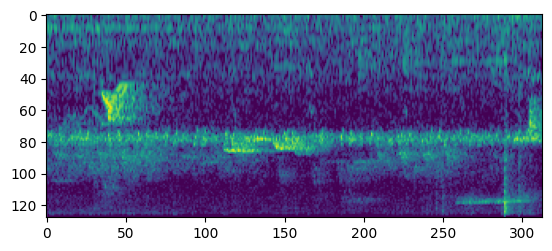

In [68]:
plt.imshow(np.array([S_db[:,:313]]).transpose(1,2,0))

In [ ]:
all_bird_data = dict()

for i, row_metadata in tqdm(meta_data.iterrows()):
                
        audio_data, _ = librosa.load(f"inputs/train_audio/{row_metadata.filename}", sr=default_config["SAMPLE_RATE"])

        n_copy = math.ceil(5 * default_config["SAMPLE_RATE"] / len(audio_data))
        if n_copy > 1: audio_data = np.concatenate([audio_data]*n_copy)

        # for start_idx in range(0,len(audio_data)-(len(audio_data)%(5*default_config["SAMPLE_RATE"])),5*default_config["SAMPLE_RATE"]):
        # start_idx = int(start_idx)
        # start_idx = int(len(audio_data) / 2 - 2.5 * default_config["SAMPLE_RATE"])
        birdcall = google_start_birdcall[row_metadata.filename]
        if len(birdcall) > 5: tak = 5 
        else: tak = len(birdcall)

        for second in birdcall[:tak]:
                start_idx = int(second * default_config["SAMPLE_RATE"])
                end_idx = int((second + 5.0) * default_config["SAMPLE_RATE"])
                input_audio = audio_data[start_idx:end_idx]

                # ogg to spec.
                input_spec = oog2melspec_via_librosa(input_audio)

                print(input_spec.shape)

                input_spec = cv2.resize(input_spec, (256, 256), interpolation=cv2.INTER_AREA)

                all_bird_data[f"{row_metadata.filename}_{start_idx}"] = input_spec.astype(np.float32)
# save to file
np.save(os.path.join("data", f'melspec_googletop5_256_256_24_wide.npy'), all_bird_data)

In [6]:
# f = open("data/duplicates.txt", 'r').readlines()
# dup = [row.split(',')[0] for row in f]
# print(f"Get {len(dup)} duplicates file")
# for d in dup:
#     meta_data = meta_data[meta_data.filename!=d]
# meta_data.reset_index(drop=True)
# meta_data.drop_duplicates(subset=['filename'], inplace=True)
# meta_data.reset_index(drop=True, inplace=True)
# meta_data

### Mel Spectogram

In [8]:
normar = albu.Compose([
        albu.Normalize()
    ])

def oog2melspec (audio_data):
    mel_transform = torchaudio.transforms.MelSpectrogram(sample_rate=default_config["SAMPLE_RATE"],
                                                         n_fft=default_config["N_FFT"],
                                                         f_min=default_config["MIN_FREQ"], f_max=default_config["MAX_FREQ"], hop_length=default_config["HOP_LENGTH"],
                                                         normalized=True, center=True, onesided=True,
                                                         pad_mode="constant", norm="slaney", mel_scale="slaney")
    db_transform = torchaudio.transforms.AmplitudeToDB(stype='power', top_db=80)

    mel_spectrogram = db_transform(mel_transform(audio_data))
    # mel_spectrogram = mel_spectrogram.expand(3, -1, -1).permute(1, 2, 0).numpy()

    return mel_spectrogram.numpy()

0it [00:00, ?it/s]

C:\Users\hoang\AppData\Local\Temp\ipykernel_11752\578890562.py:8: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  librosa.display.specshow(sgram, ax=axs[1])


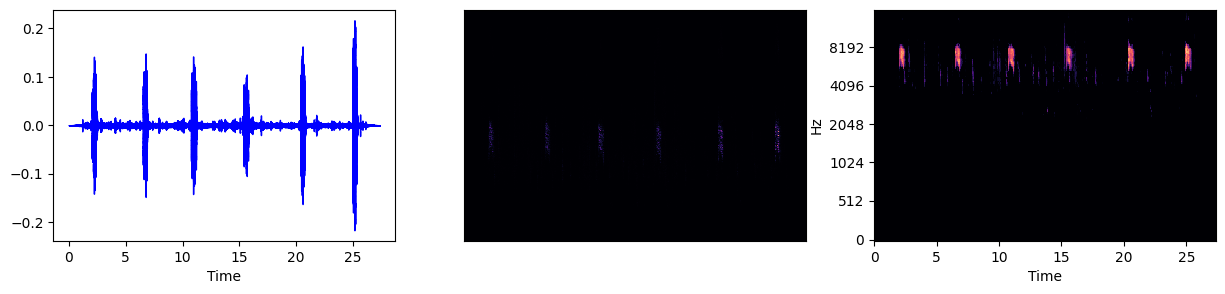

1it [00:01,  1.30s/it]

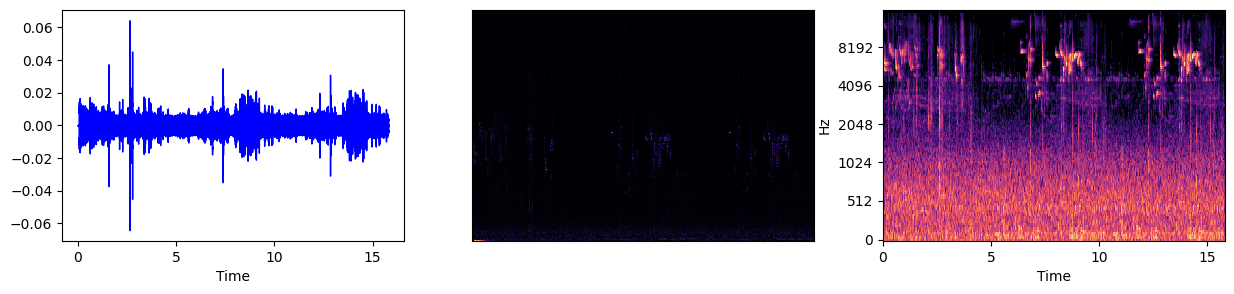

2it [00:02,  1.06s/it]

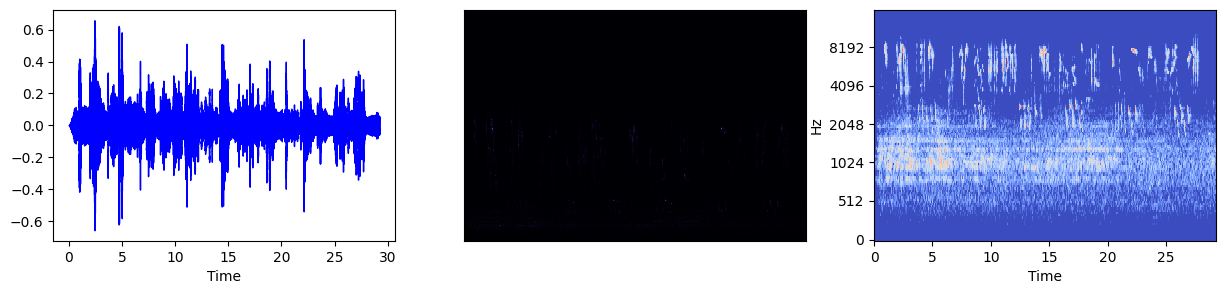

3it [00:03,  1.20s/it]

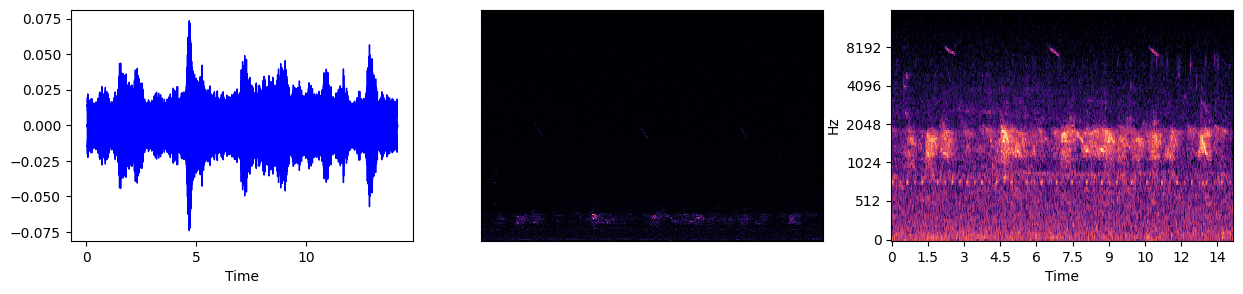

4it [00:04,  1.08s/it]

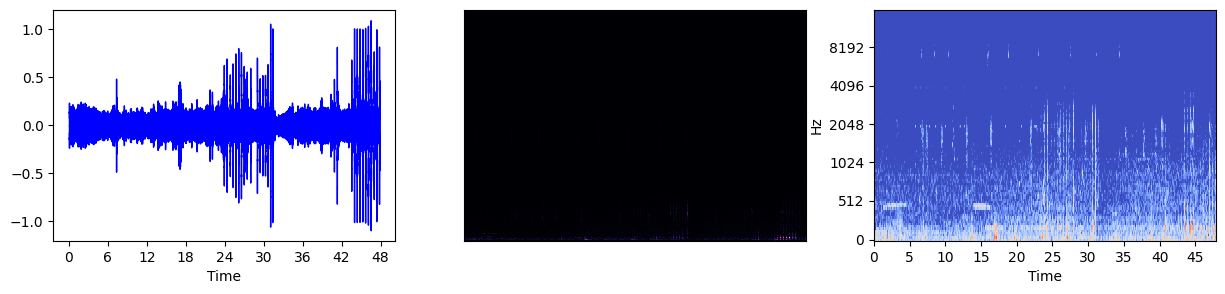

5it [00:06,  1.40s/it]

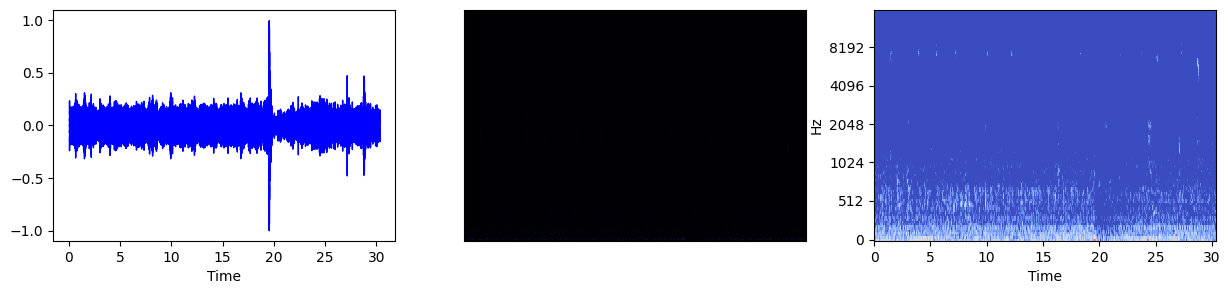

6it [00:07,  1.40s/it]

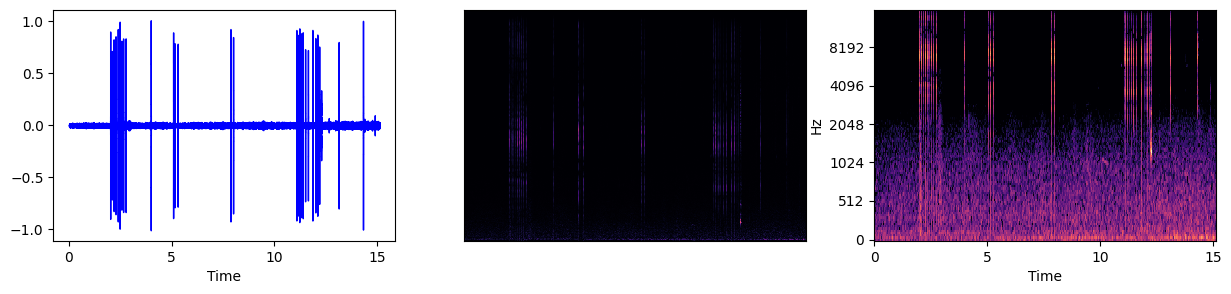

7it [00:08,  1.21s/it]

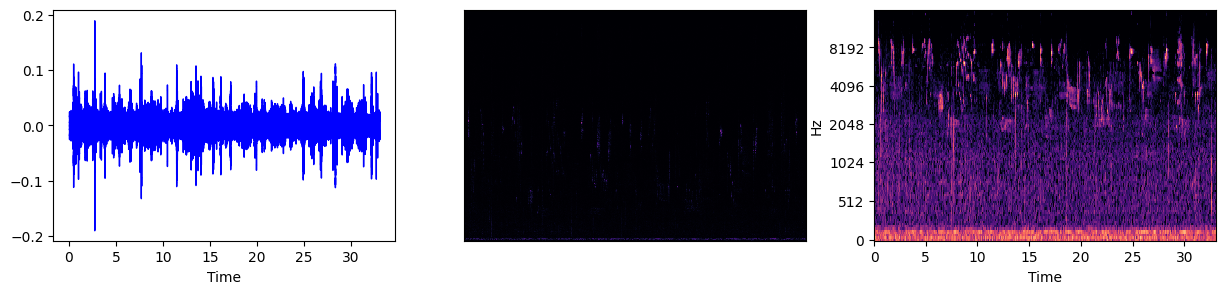

8it [00:10,  1.43s/it]

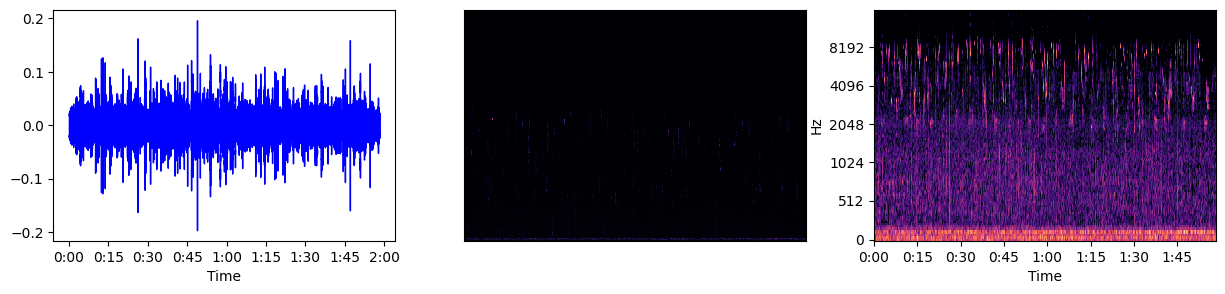

9it [00:14,  2.34s/it]

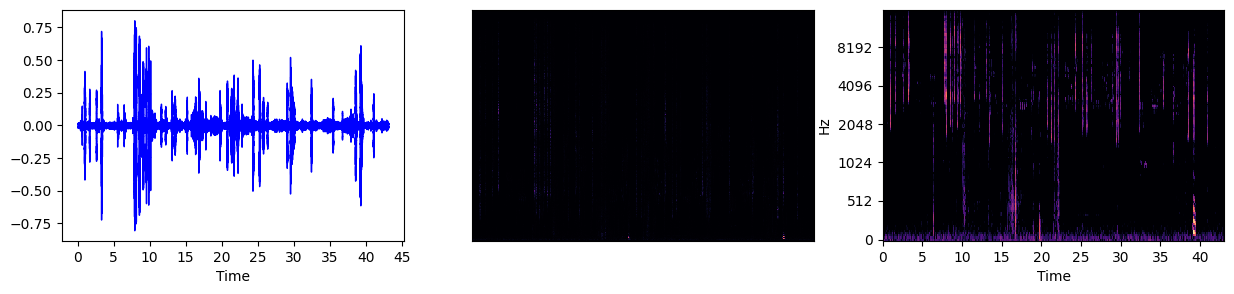

10it [00:16,  2.20s/it]

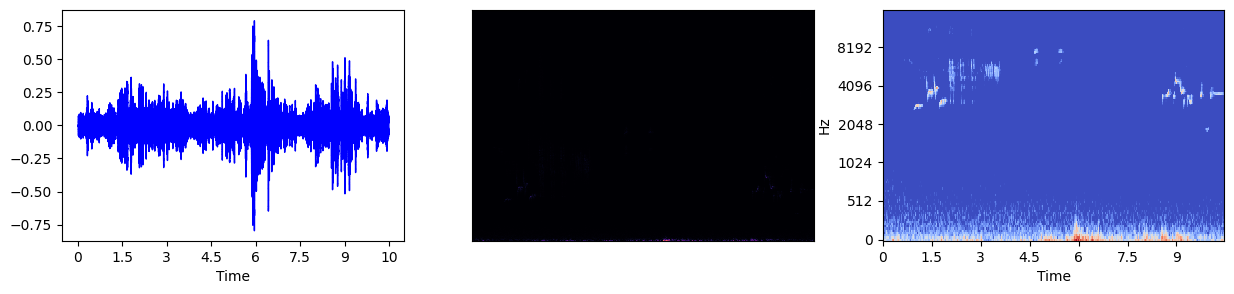

10it [00:17,  1.75s/it]


In [12]:
for i, row_metadata in tqdm(meta_data.iterrows()):
        fig, axs = plt.subplots(1,3, figsize=(15,3))
        display(Audio(f"inputs/train_audio/{row_metadata.filename}"))
        audio_data, sample_rate = librosa.load(f"inputs/train_audio/{row_metadata.filename}", sr=default_config["SAMPLE_RATE"])
        librosa.display.waveshow(audio_data, sr=default_config["SAMPLE_RATE"], color="blue", ax=axs[0])

        sgram = librosa.stft(audio_data)
        librosa.display.specshow(sgram, ax=axs[1])

        mel_scale_sgram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, 
                                                         n_mels=default_config["N_MEL"], hop_length=default_config["HOP_LENGTH"], 
                                                         center=True, pad_mode='constant', 
                                                         fmin=default_config['MIN_FREQ'], fmax=default_config["MAX_FREQ"],
                                                         n_fft=default_config["N_FFT"], norm="slaney", htk=False)
        mel_sgram = librosa.amplitude_to_db(mel_scale_sgram, top_db=80)
        librosa.display.specshow(mel_sgram, sr=default_config["SAMPLE_RATE"], x_axis='time', y_axis='mel', ax=axs[2])   
        plt.show()

        if i==10:
                break

In [13]:
mel_sgram

array([[  3.7591305 ,  17.397892  ,  14.4594    , ...,  20.648594  ,
         25.011803  ,  21.121891  ],
       [  0.9376684 ,   8.1968565 ,  11.27839   , ...,  11.302028  ,
         14.321239  ,   0.60262775],
       [ -4.13701   ,  11.315565  ,   9.632945  , ...,   4.0655956 ,
          4.2033668 ,   3.1507473 ],
       ...,
       [-18.322723  , -18.322723  , -18.322723  , ..., -18.322723  ,
        -18.322723  , -18.322723  ],
       [-18.322723  , -18.322723  , -18.322723  , ..., -18.322723  ,
        -18.322723  , -18.322723  ],
       [-18.322723  , -18.322723  , -18.322723  , ..., -18.322723  ,
        -18.322723  , -18.322723  ]], dtype=float32)

In [19]:
normalize_melspec(torch.tensor(mel_sgram))

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

In [13]:
all_bird_data = dict()

for i, row_metadata in tqdm(meta_data.iterrows()):
        audio_data, org_sr = torchaudio.load(f"inputs/train_audio/{row_metadata.filename}", normalize=True)
        audio_data = torchaudio.functional.resample(audio_data, orig_freq=org_sr, new_freq=default_config["SAMPLE_RATE"])

        while audio_data.size(-1) < 5:
                audio_data = torch.cat([audio_data, audio_data], dim=1)

        birdcall = google_start_birdcall[row_metadata.filename]
        if len(birdcall) > 5: tak = 5 
        else: tak = len(birdcall)

        for second in birdcall[:tak]:
                start_idx = int(second)
                end_idx = int(second + 5.0)
                input_audio = audio_data[:, start_idx:end_idx]
                # ogg to spec.
                input_spec = oog2melspec(input_audio)

                input_spec = cv2.resize(input_spec, (256, 256), interpolation=cv2.INTER_AREA)

                all_bird_data[f"{row_metadata.filename}_{start_idx}"] = input_spec.astype(np.float32)
# save to file
np.save(os.path.join("data", f'melspec_google1s_5sectop5_256_256_3_24.npy'), all_bird_data)

24459it [16:52, 24.17it/s]


### Extract No Call class

In [ ]:
from pydub import AudioSegment
import os

In [ ]:
os.environ["PATH"] += os.pathsep + 'C:/Users/hoang/Downloads/ffmpeg-master-latest-win64-gpl-shared/bin/ffmpeg.exe'
os.environ["PATH"] += os.pathsep + 'C:/Users/hoang/Downloads/ffmpeg-master-latest-win64-gpl-shared/bin/ffplay.exe'
os.environ["PATH"] += os.pathsep + 'C:/Users/hoang/Downloads/ffmpeg-master-latest-win64-gpl-shared/bin/ffprobe.exe'

In [ ]:
AudioSegment.converter = 'C:/Users/hoang/Downloads/ffmpeg-master-latest-win64-gpl-shared/bin/ffmpeg.exe'
AudioSegment.ffmpeg = 'C:/Users/hoang/Downloads/ffmpeg-master-latest-win64-gpl-shared/bin/ffmpeg.exe'
AudioSegment.ffprobe =  'C:/Users/hoang/Downloads/ffmpeg-master-latest-win64-gpl-shared/bin/ffprobe.exe'

In [ ]:
p = "inputs/previous_dataset/ColumbiaAndCostaRica" # SouthwesternAmazonBasin" # WesternUS"
anno = pd.read_csv(f"{p}/annotations.csv")
anno = anno[anno["Species eBird Code"]=="????"].reset_index(drop=True)
anno

Filename  Start Time (s)  End Time (s)  \
0    NES_001_S01_20190914_043000.flac          1980.9        1981.3   
1    NES_001_S01_20190914_043000.flac          1991.8        1992.3   
2    NES_001_S01_20190914_043000.flac          1993.7        1994.1   
3    NES_001_S01_20190914_043000.flac          1996.3        1996.8   
4    NES_001_S01_20190914_043000.flac          2539.1        2539.4   
..                                ...             ...           ...   
381  NES_032_S02_20191009_063001.flac          3587.6        3588.2   
382  NES_032_S02_20191009_063001.flac          3591.7        3592.2   
383  NES_033_S02_20191009_160000.flac          1368.5        1370.9   
384  NES_034_S02_20191009_170000.flac          2507.6        2508.4   
385  NES_034_S02_20191009_170000.flac          3194.9        3198.2   

     Low Freq (Hz)  High Freq (Hz) Species eBird Code  
0             7183           10000               ????  
1             7042           10845               ????  
2             7323            9718               ????  
3             7042           10281               ????  
4             7464            9859               ????  
..             ...             ...                ...  
381           4354            9516               ????  
382           5000           10161               ????  
383           3559            6271               ????  
384              0            2372               ????  
385           2711            6101               ????  

[386 rows x 6 columns]

In [ ]:
for idx in tqdm(range(len(anno))):
    if (anno["End Time (s)"][idx]- anno["Start Time (s)"][idx]) > 5:

        newAudio = AudioSegment.from_file(f"{p}/soundscape_data/{anno['Filename'][idx]}", 'flac')
        newAudio = newAudio[anno['Start Time (s)'][idx]*1000:anno['End Time (s)'][idx]*1000]
        newAudio.export(f'inputs/train_audio/nocall/ColumbiaAndCostaRica_{idx}.ogg', format="ogg")


100%|██████████| 386/386 [02:57<00:00,  2.17it/s]


In [ ]:
noCallFiles = glob("inputs/train_audio/nocall/*.ogg")
meta_data = pd.DataFrame(noCallFiles, columns=["filename"])
meta_data

filename
0    inputs/train_audio/nocall\ColumbiaAndCostaRica...
1    inputs/train_audio/nocall\ColumbiaAndCostaRica...
2    inputs/train_audio/nocall\ColumbiaAndCostaRica...
3    inputs/train_audio/nocall\ColumbiaAndCostaRica...
4    inputs/train_audio/nocall\ColumbiaAndCostaRica...
..                                                 ...
296  inputs/train_audio/nocall\SouthwesternAmazonBa...
297  inputs/train_audio/nocall\SouthwesternAmazonBa...
298  inputs/train_audio/nocall\SouthwesternAmazonBa...
299  inputs/train_audio/nocall\SouthwesternAmazonBa...
300  inputs/train_audio/nocall\SouthwesternAmazonBa...

[301 rows x 1 columns]

In [ ]:
def clean_filename(row):
    return row.split("/")[-1].replace("\\","/")

meta_data["filename"] = meta_data["filename"].apply(clean_filename)
meta_data

filename
0       nocall/ColumbiaAndCostaRica_102.ogg
1       nocall/ColumbiaAndCostaRica_103.ogg
2       nocall/ColumbiaAndCostaRica_106.ogg
3        nocall/ColumbiaAndCostaRica_11.ogg
4       nocall/ColumbiaAndCostaRica_111.ogg
..                                      ...
296  nocall/SouthwesternAmazonBasin_987.ogg
297  nocall/SouthwesternAmazonBasin_989.ogg
298  nocall/SouthwesternAmazonBasin_993.ogg
299  nocall/SouthwesternAmazonBasin_994.ogg
300  nocall/SouthwesternAmazonBasin_995.ogg

[301 rows x 1 columns]

In [ ]:
all_bird_data = dict()

for i, row_metadata in tqdm(meta_data.iterrows()):
                
        audio_data, _ = librosa.load(f"inputs/train_audio/{row_metadata.filename}", sr=default_config["SAMPLE_RATE"])

        n_copy = math.ceil(5 * default_config["SAMPLE_RATE"] / len(audio_data))
        if n_copy > 1: audio_data = np.concatenate([audio_data]*n_copy)

        # for start_idx in range(0,len(audio_data)-(len(audio_data)%(5*default_config["SAMPLE_RATE"])),5*default_config["SAMPLE_RATE"]):
        # start_idx = int(start_idx)
        # start_idx = int(len(audio_data) / 2 - 2.5 * default_config["SAMPLE_RATE"])
        start_idx = 0
        end_idx = int(start_idx + 5.0 * default_config["SAMPLE_RATE"])
        input_audio = audio_data[start_idx:end_idx]

        # ogg to spec.
        input_spec = oog2spec_via_cupy(input_audio)

        input_spec = cv2.resize(input_spec, (256, 256), interpolation=cv2.INTER_AREA)

        all_bird_data[f"{row_metadata.filename}_{start_idx}"] = input_spec.astype(np.float32)
# save to file
np.save(os.path.join("data", f'spec_first_5sec_256_256_nocall.npy'), all_bird_data)

301it [00:08, 35.51it/s]


### bird-vocalization-classifier || Google

In [ ]:
label = pd.read_csv("inputs/bird-vocalization-classifier/assets/label.csv")

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_io as tfio

In [7]:
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 5.0,
      hop_size_s: float = 5.0,
      sample_rate = 32000,
  ) -> np.ndarray:
    """Helper function for framing audio for inference."""
    if window_size_s is None or window_size_s < 0:
      return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

In [71]:
filepath = random.choice(glob("inputs/train_audio/*/*.ogg"))
# filepath = "inputs/train_audio/commoo3/XC645668.ogg"
# filepath = "inputs/train_audio/rerswa1/XC697561.ogg"
audio, sample_rate = librosa.load(filepath, sr=32000)

n_copy = math.ceil(5 *32000 / len(audio))
if n_copy > 1: audio = np.concatenate([audio]*n_copy)

print(filepath)
display(Audio(filepath))

s5_audio = []
list_start_second = []
duration = len(audio)/32000
last_5s = duration-(duration%5)-5
start_second = 0

while start_second<=last_5s:
        start_idx = int(start_second*32000)
        end_idx = int((start_second+5.0) * 32000)
        
        input_audio = audio[start_idx:end_idx]

        list_start_second.append((start_second,end_idx/32000))
        s5_audio.append(frame_audio(input_audio))

        start_second +=1

input_spec = oog2spec_via_cupy(audio)


inputs/train_audio\lirplo\XC562310.ogg


Bird call (9, 14.0)s


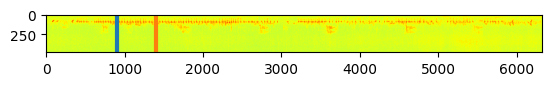

In [72]:
# Load the model.
model = hub.load('https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8')

specices_logits = []
score = []
for au in s5_audio:
    probabilities = tf.nn.sigmoid(model.infer_tf(au)["label"])
    score.append(probabilities.numpy()[0].sum())

print(f"Bird call {list_start_second[np.argmax(score)]}s")

x = [x for x in range(np.squeeze(input_spec).shape[0])]
y = np.empty(len(x))
y.fill(list_start_second[np.argmax(score)][0]*100)

plt.plot(y,x,linewidth=3) 

y.fill(list_start_second[np.argmax(score)][1]*100)
plt.plot(y,x,linewidth=3) 

plt.imshow(np.squeeze(input_spec), cmap='jet')
plt.show()

In [ ]:
all_bird_data = dict()
model = hub.load('https://www.kaggle.com/models/google/bird-vocalization-classifier/TensorFlow2/bird-vocalization-classifier/8')

for i, row_metadata in tqdm(meta_data.iterrows()):
                
        audio_data, _ = librosa.load(f"inputs/train_audio/{row_metadata.filename}", sr=default_config["SAMPLE_RATE"])

        n_copy = math.ceil(5 * default_config["SAMPLE_RATE"] / len(audio_data))
        if n_copy > 1: audio_data = np.concatenate([audio_data]*n_copy)

        start_second = []
        s5_audio = []

        for start_idx in range(0,len(audio_data)-(len(audio_data)%(5*32000)),5*32000):
            start_idx = int(start_idx)
            end_idx = int(start_idx + 5.0 * 32000)
            input_audio = audio_data[start_idx:end_idx]
            start_second.append(start_idx/32000)
            s5_audio.append(frame_audio(input_audio))

        specices_logits = []
        score = []
        for au in s5_audio:
            probabilities = tf.nn.sigmoid(model.infer_tf(au)["label"])
            score.append(probabilities.numpy()[0].sum())

        start_idx = int(start_second[np.argmax(score)])
        end_idx = int(start_idx + 5.0 * default_config["SAMPLE_RATE"])
        input_audio = audio_data[start_idx:end_idx]

        # ogg to spec.
        input_spec = oog2spec_via_cupy(input_audio)

        input_spec = cv2.resize(input_spec, (256, 256), interpolation=cv2.INTER_AREA)

        all_bird_data[f"{row_metadata.filename}_{start_idx}"] = input_spec.astype(np.float32)
# save to file
np.save(os.path.join("data", f'spec_google_5sec_256_256_24.npy'), all_bird_data)

In [14]:
class BirdCLEF_Model_EfficientnetB0(nn.Module):
    def __init__(self, num_class):
        super(BirdCLEF_Model_EfficientnetB0, self).__init__()
        self.backbone = timm.create_model('tf_efficientnet_b0.in1k', pretrained=True, in_chans=1,  num_classes=num_class)
    
    def forward(self, x):
        x = self.backbone(x)
        return x

In [16]:
input_tensor = torch.randn(16, 1, 256, 256)

from openvino.runtime import Core
import openvino as ov


for fold in range(1):
    bird_model = BirdCLEF_Model_EfficientnetB0(num_class=182)
    weights = torch.load(f"model/v2.0/BaseModel_EfficientB0_Fold{fold}.pt", map_location=torch.device('cpu'))
    bird_model.load_state_dict(weights)
    bird_model.eval()

    ov_model = ov.convert_model(bird_model, example_input=input_tensor)
    ov.save_model(ov_model, f"model/v2.0/BaseModel_EfficientB0_Fold{fold}.xml")